In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [11]:
from parse_data import load_data

df = load_data()
print("Loaded df shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Loaded df shape: (201, 9)
Columns: ['Country', 'Year', 'ISO', 'Population', 'Electricity demand', 'GHG emissions', 'FF electricity share', 'RE electricity share', 'Income Group FY23']


,Country,Year,ISO,Population,Electricity demand,GHG emissions,FF electricity share,RE electricity share,Income Group FY23
1,Albania,2021,ALB,2849591.0,8.39,0.21,0.000,100.000,UM
2,Algeria,2021,DZA,44761051.0,84.45,54.23,99.054,0.946,LM
3,American Samoa,2021,ASM,49202.0,0.17,0.11,100.000,0.000,UM
4,Angola,2021,AGO,34532382.0,16.85,2.91,24.570,75.430,LM
5,Antigua and Barbuda,2021,ATG,92316.0,0.35,0.22,94.286,5.714,H


In [12]:
# Detect target (DV): renewables share
target_candidates = ["RE electricity share", "renewables_share_elec"]
target = next((c for c in target_candidates if c in df.columns), None)

if target is None:
    raise ValueError("Could not find renewables share column in df.")

print("Using target:", target)

# Drop non-features
drop_cols = [target]

# drop identifiers if present
for c in ["Country", "country", "ISO", "iso_code", "Year", "year", "Country Name"]:
    if c in df.columns:
        drop_cols.append(c)

# X and y
X = df.drop(columns=drop_cols)

y = df[target]
print("X shape before processing:", X.shape)

Using target: RE electricity share
X shape before processing: (201, 5)


In [15]:
# If income group column exists, one-hot encode it
if "Income Group FY23" in X.columns:
    X = pd.get_dummies(X, columns=["Income Group FY23"], drop_first=True)

X = X.select_dtypes(include=np.number)

print("Final X shape:", X.shape)
print("Sample columns:", X.columns.tolist()[:12])

Final X shape: (201, 4)
Sample columns: ['Population', 'Electricity demand', 'GHG emissions', 'FF electricity share']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])

Train rows: 160 Test rows: 41


In [17]:
models = {
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    )
}

In [21]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
trained = {}

for name, model in models.items():
    # CV RMSE (on training set)
    cv_scores = cross_val_score(
        model,
        X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=cv
    )
    cv_rmse = (-cv_scores).mean()

    # Fit and test
model.fit(X_train, y_train)
pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, pred)
test_r2 = r2_score(y_test, pred)


rows.append([name, cv_rmse, test_rmse, test_mae, test_r2])
trained[name] = {"model": model, "pred": pred}

results = pd.DataFrame(rows, columns=["model", "cv_rmse", "test_rmse", "test_mae", "test_r2"]).sort_values("test_rmse")
results

,model,cv_rmse,test_rmse,test_mae,test_r2
0,RandomForest,8.601624,15.022239,6.92011,0.78949


In [22]:
best_name = results.iloc[0]["model"]
best_model = trained[best_name]["model"]
best_pred = trained[best_name]["pred"]

print("Best model:", best_name)

Best model: RandomForest


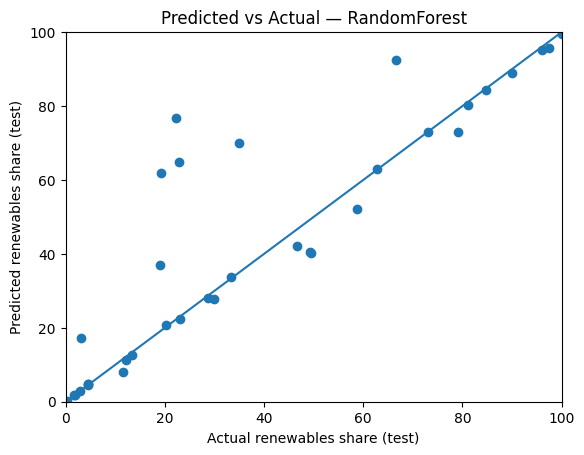

Saved fig1_pred_vs_actual.png


In [23]:
#Fig 1. Predicted vs Actual (main result)
plt.figure()
plt.scatter(y_test, best_pred)
plt.xlabel("Actual renewables share (test)")
plt.ylabel("Predicted renewables share (test)")
plt.title(f"Predicted vs Actual — {best_name}")

lo = min(y_test.min(), best_pred.min())
hi = max(y_test.max(), best_pred.max())
plt.plot([lo, hi], [lo, hi])
plt.xlim(lo, hi)
plt.ylim(lo, hi)

plt.savefig("fig1_pred_vs_actual.png", dpi=200, bbox_inches="tight")
plt.show()
print("Saved fig1_pred_vs_actual.png")

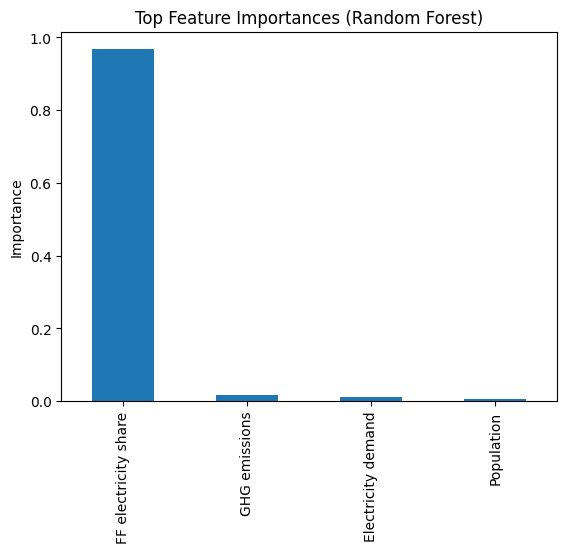

Saved fig2_feature_importance.png


In [25]:
#Fig 2. Feature importance (main result)
from sklearn.inspection import permutation_importance

plt.figure()

if best_name == "RandomForest":
    importances = best_model.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    feat_imp.head(12).plot(kind="bar")
    plt.ylabel("Importance")
    plt.title("Top Feature Importances (Random Forest)")

else:
    perm = permutation_importance(
        best_model,
        X_test, y_test,
        n_repeats=20,
        random_state=42,
        scoring="neg_root_mean_squared_error"
    )
    perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

    perm_imp.head(12).plot(kind="bar")
    plt.ylabel("Permutation importance (RMSE impact)")
    plt.title(f"Top Feature Importances (Permutation) — {best_name}")

plt.savefig("fig2_feature_importance.png", dpi=200, bbox_inches="tight")
plt.show()
print("Saved fig2_feature_importance.png")

In [26]:
results.to_csv("ml_results_summary.csv", index=False)
print("Saved ml_results_summary.csv")

Saved ml_results_summary.csv
